In [1]:
import numpy as np
import matplotlib.pyplot as plt
path = './sample_nonlinear_data.csv'

# SPICEnet Basics

The basic network consists of two populations, A and B, of neurons. At the moment pair-wise correlations can only be learned. The system is extensible (with effort) to n-uple correlations learning.

Assume population A receives input from sensor X and population B receives input from sensor Y, respectively. The units in A get input from an external source X by point-to-point connections, i.e., each unit in A receives input from exactly one unit in X and each unit in X sends input to exactly one unit in A. Similarly, a second input Y, is connected to B by point-to-point connections. X and Y are supposed to encode one single scalar value each (i.e. timeseries encoded in a population of neurons).

![](network.png)

Projection diagram of the sample network discussed in the text: two populations with bidirectional connectivity. Labeled ellipses represent populations of neural nodes. Dark gray arrows depict directed, full connectivity, light gray arrows indicate point to point connections used to feed population coded input into the network. Blue dots show one possible input of this kind.

The units within each of the populations A and B are laterally interconnected The connection weight $w_{i,j}$ between units i and j is defined as:

![](dynamics1.png)

Basically the learning happens at 3 levels:
* neuron level learning (homeostatic regulation, HAR)
![](dynamics2.png)

* within population learning (winner-take-all, WTA)
![](dynamics3.png)

* between population learning (hebbian learning, HL)
![](dynamics4.png)

The WTA dynamics operate on a short time scale, allowing the network to converge quickly. HAR and HL operate on a much longer time scale, averaging over a much larger sample of inputs.

The system employs a combination of three strategies. Synaptic connections between areas are controlled by Hebbian learning (HL). Local connections within an area support soft winner-take-all (WTA) dynamics, so nearby units within an area exhibit similar activity patterns. Homeostatic activity regulation (HAR) within each unit modulates the Hebbian learning so that a unit does not become permanently active or inactive, but maintains a desired average activity level.

![](network-dynamics.png)

In [2]:
# compute the value of the logistic function for single neuron dynamics
# given the slope, m, and the shift, s
def compute_s(x, m ,s):
    y = np.zeros((len(x), 1))
    for idx in range(len(x)):
        y[idx, 0] = 1/(1 + np.exp(-m*(x[idx, 0] - s)))
    return y

In [3]:
# compute distance d
def compute_d(N, s):
    y = np.zeros((N, N))
    for idx in range(N):
        for jdx in range(N):
            y[idx, jdx] = np.exp(-0.5*(np.min([np.abs(idx-jdx), N - np.abs(idx-jdx)])/s) ** 2)
    return y

In [4]:
# create the learning network composed of N_POP populations of
# N_NEURONS neurons and init each struct weight and activity matrices
def create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT):
    wta_profile = GAMMA * compute_d(N_NEURONS, SIGMA) - DELTA;
    wext = np.random.rand(N_NEURONS, N_NEURONS)*MAX_INIT_RANGE;
    populations = {}
    for pop_idx in range(N_POP):
        populations[pop_idx] = {'idx': pop_idx,
                                'lsize': N_NEURONS,
                                'Wint': wta_profile,
                                'Wext': wext / np.sum(wext),
                                'a': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT,
                                'h': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT
                               }
    return populations

In [6]:
# function to generate the population encoded variable as input for the net
# here we also need to encode variables which are in both +/- ranges
# we need to take into accound the encoding for the tuning curves distribution
def population_encoder(x, range_input, N):
    sig = .1  # Standard deviation
    K = 1; # max firing rate (Hz)
    # pattern of activity, or output tuning curve between [-range, range]
    R = np.zeros((N, 1))
    # calculate output 
    for j in range(N):  # for each neuron in the population
        R[j, 0] = K*np.exp( -(x - (-range_input+(j)*(range_input/((N)/2))))**2 / (2*sig**2))
    return R

In [7]:
# Read csv / dataset
def read_sensor(path):
    return np.genfromtxt(path, delimiter = ',')

In [8]:
# print learnt relation
def print_heatmap(arr):
    plt.figure()
    plt.imshow(arr)
    plt.show()

In [16]:
## INIT SIMULATION
# enables dynamic visualization on network runtime
DYN_VISUAL      = 1
# number of populations in the network
N_POP           = 2
# number of neurons in each population
N_NEURONS       = 200
# max range value @ init for weights and activities in the population
MAX_INIT_RANGE  = 1
# WTA circuit settling threshold
EPSILON         = 1e-3

# get data from file 
sensory_data = read_sensor(path)
# simulate some data
power_law = 2
x =  np.random.uniform(-1,1,250)
y = pow(x, power_law) # pow, sin, etc....
y = x**3;
sensory_data = np.vstack((x, y))
sensory_data = sensory_data.transpose()

DATASET_LEN     = len(sensory_data[:, 0])
## INIT NETWORK DYNAMICS
# epoch iterator in outer loop (HL, HAR)
t       = 1;
# network iterator in inner loop (WTA)
tau     = 1;
# constants for WTA circuit (convolution based WTA), these will provide a
# profile peaked at ~ TARGET_VAL_ACT
DELTA   = -0.005                   # displacement of the convolutional kernel (neighborhood)
SIGMA   = 5.0                      # standard deviation in the exponential update rule
SL      = 4.5                      # scaling factor of neighborhood kernel
GAMMA   = SL/(SIGMA*np.sqrt(2*np.pi))    # convolution scaling factor
# constants for Hebbian linkage
ALPHA_L = 1.0*1e-2                 # Hebbian learning rate
ALPHA_D = 1.0*1e-2                 # Hebbian decay factor ALPHA_D >> ALPHA_L
# constants for HAR
C       = 0.005                    # scaling factor in homeostatic activity regulation
TARGET_VAL_ACT  = 0.4              # amplitude target for HAR
A_TARGET        = TARGET_VAL_ACT*np.ones((N_NEURONS, 1)) # HAR target activity vector
# constants for neural units in neural populations
M       = 1; # slope in logistic function @ neuron level
S       = 10.0; # shift in logistic function @ neuron level
# activity change weight (history vs. incoming knowledge)
ETA     = 0.25;
## CREATE NETWORK AND INITIALIZE
# create a network given the simulation constants
populations = create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT)
# buffers for changes in activity in WTA loop
act = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
old_act = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
# buffers for running average of population activities in HAR loop
old_avg = np.zeros((N_POP, N_NEURONS))
cur_avg = np.zeros((N_POP, N_NEURONS))
# the new rate values
delta_a1 = np.zeros((N_NEURONS, 1))
## NETWORK SIMULATION LOOP
# # present each entry in the dataset for MAX_EPOCHS epochs to train the net

for didx in range(DATASET_LEN):
    # pick a new sample from the dataset and feed it to the input (noiseless input)
    # population in the network (in this case X -> A -> | <- B <- Y)
    X = population_encoder(sensory_data[didx, 0], np.max(sensory_data[:, 0]),  N_NEURONS)
    Y = population_encoder(sensory_data[didx, 1], np.max(sensory_data[:, 1]),  N_NEURONS)
    # normalize input such that the activity in all units sums to 1.0
    X /= np.sum(X);
    Y /= np.sum(Y);
    # clamp input to neural populations
    populations[0]['a'] = X;
    populations[1]['a'] = Y;
    # given the input sample wait for WTA circuit to settle and then
    # perform a learning step of Hebbian learning and HAR
    while True:
        # compute changes in activity
        delta_a0 = compute_s(populations[0]['h'] + np.matmul(populations[0]['Wext'], populations[1]['a']) + 
                             np.matmul(populations[0]['Wint'],populations[0]['a']), 
                             M, 
                             S)
        delta_a1 = compute_s(populations[1]['h'] + np.matmul(populations[1]['Wext'], populations[0]['a']) + 
                             np.matmul(populations[1]['Wint'], populations[1]['a']), 
                             M, 
                             S)
        # update the activities of each population
        populations[0]['a'] = (1-ETA)*populations[0]['a'] + ETA*delta_a0
        populations[1]['a'] = (1-ETA)*populations[1]['a'] + ETA*delta_a1
        # current activation values holder
        for pop_idx in range(N_POP):
            act[:, pop_idx] = populations[pop_idx]['a'].reshape(-1)
        # check if activity has settled in the WTA loop
        q = (np.sum(np.sum(np.abs(act - old_act)))/(N_POP*N_NEURONS))
        if q <= EPSILON:
            tau = 1
            break
        # update history of activities
        old_act = act
        # increment time step in WTA loop
        tau += 1
    # update Hebbian linkage between the populations (decaying Hebbian rule)
    populations[0]['Wext'] = (1-ALPHA_D)*populations[0]['Wext'] + ALPHA_L*np.matmul(populations[0]['a'],populations[1]['a'].transpose())
    populations[1]['Wext'] = (1-ALPHA_D)*populations[1]['Wext'] + ALPHA_L*np.matmul(populations[1]['a'],populations[0]['a'].transpose())
    # compute the inverse time for exponential averaging of HAR activity
    omegat = 0.002 + 0.998/(t+2)
    # for each population in the network
    for pop_idx in range(N_POP):
        # update Homeostatic Activity Regulation terms
        # compute exponential average of each population at current step
        cur_avg[pop_idx, :] = (1-omegat)*old_avg[pop_idx, :] + omegat*populations[pop_idx]['a'].transpose()
        # update homeostatic activity terms given current and target act.
        populations[pop_idx]['h'] = populations[pop_idx]['h'] + C*(TARGET_VAL_ACT - cur_avg[pop_idx, :].transpose())
    # update averging history
    old_avg = cur_avg
    # increment timestep for HL and HAR loop
    t = t + 1

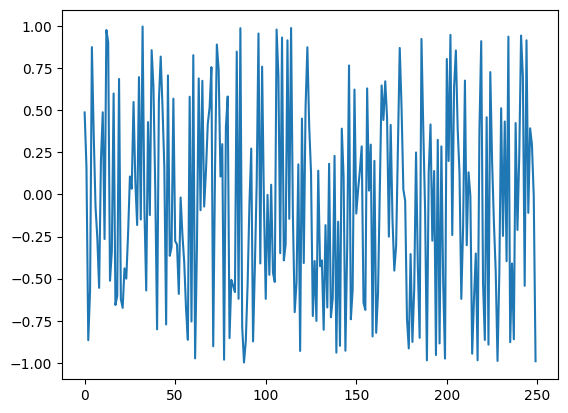

In [17]:
plt.plot(sensory_data[:, 0])

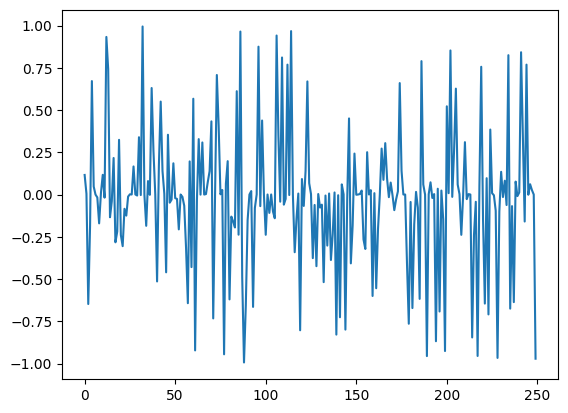

In [18]:
plt.plot(sensory_data[:, 1])

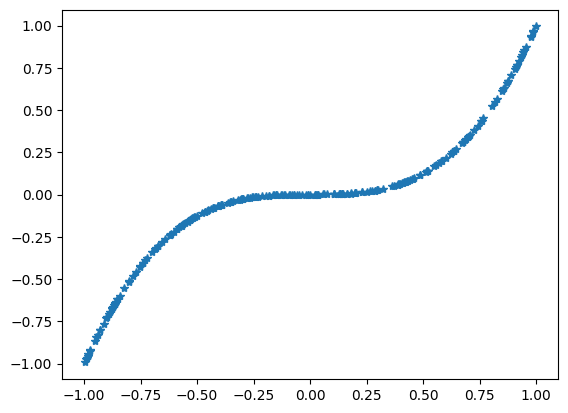

In [19]:
plt.plot(sensory_data[:, 0], sensory_data[:, 1], '*')

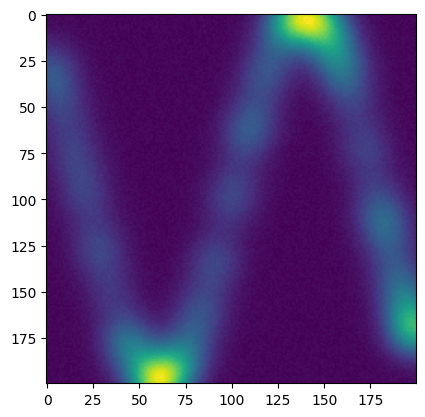

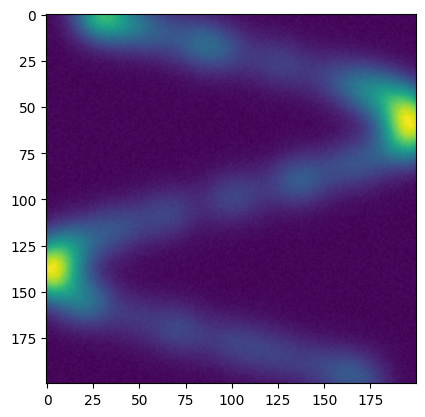

In [14]:
print_heatmap(np.rot90(populations[0]['Wext']))
print_heatmap(np.rot90(populations[1]['Wext']))

# Decoder Logic

- find max activation in the mapped activation - useful in extracting a first guess of the decoded value in the diustance optimizer
- Brent's decoder
https://github.com/caxenie/corr-learn-som-fast/blob/master/src/network.c

- find largest and lowest activation in each population and the index, idxL, idxH
- use the index to recover the weight (Winput[idxL], Winput[idxH])
- call decoder using smallest and largest weight (limL = min(Winput[idxL], limH = max(Winput[idxH]))
- pre_pop and post_pop are in fact your populations[0] and populations[1] respectively

In [13]:
/* neural population definition */
typedef struct{
	short id;	/* id of the population */
	int size;	/* size of the population */
	double *Winput;/* sensory afferents synaptic connections */
	double **Wcross;/* cross modal afferents synaptic connections */
	double *s;	/* population tuning curves shapes */
	double *a;	/* population activation */
}population;

/* network definition */
typedef struct{
	short nsize;		/* number of populations in the net */
	population *pops;	/* populations in the net */
}network;

/* find max activation in the mapped activation useful in extracting a first guess of the decoded value in the diustance optimizer */
		     max_post_act = 0;
		     max_act_idx = 0;
		     for(int i=0; i<learning_runtime->sim->n->pops[post_pop].size;i++){
		 	if(learning_runtime->sim->n->pops[post_pop].a[i] > max_post_act){
				max_post_act = learning_runtime->sim->n->pops[post_pop].a[i];
				max_act_idx = i;
			}
		     }
             
/* recover the value --> decoding using optimizer  */
				if(max_act_idx == 0) idL = 0;
				else idL = max_act_idx - 1;
				if(max_act_idx == learning_runtime->sim->n->pops[post_pop].size) idH = learning_runtime->sim->n->pops[post_pop].size;
				else idH = max_act_idx + 1;
				limL = learning_runtime->sim->n->pops[post_pop].Winput[idL];
				limH = learning_runtime->sim->n->pops[post_pop].Winput[idH];
				tol= 1.0e-6; // tol = (1e-6)*fabs(limL + limH)/2.0;		
		   		learning_runtime->in->data[didx][post_pop] = decode_population(learning_runtime->sim->n, limL, limH, tol,  pre_pop, post_pop);

SyntaxError: invalid syntax (<ipython-input-13-64d2c4b78ae4>, line 1)

In [ ]:
# Brent's decoder
           
            
double decoder_metric(network*n, int pre_id, int post_id, double guess)
{
//	fact = fopen("activations.log", "a+");	
	double* dir_act = (double*)calloc(n->pops[post_id].size, sizeof(double));
	double* ind_act = n->pops[post_id].a;
	double* cur_act = (double*)calloc(n->pops[post_id].size, sizeof(double));
	double tot_act = 0.0f;
	double temp_fx = 0.0f;
	double fx = 0.0f;

	/* compute direct activation given the optimized variable */
	for(int i=0; i<n->pops[post_id].size; i++){
			cur_act[i] = (1/(sqrt(2*M_PI)*n->pops[post_id].s[i]))*
                                      exp(-pow((guess - n->pops[post_id].Winput[i]),2)/
				     (2*pow(n->pops[post_id].s[i], 2)));
				
	}
	/* normalization routine */
	for(int snid = 0; snid<n->pops[post_id].size; snid++)
                 tot_act += cur_act[snid];
        for(int snid = 0; snid<n->pops[post_id].size; snid++)
                 cur_act[snid] /= tot_act;
        /* update the activity for next iteration */
	dir_act = cur_act;
	/* function to optimize is the error between the direct and indirect activation */
	for(int i=0;i<n->pops[post_id].size;i++)
		temp_fx += pow(ind_act[i] - dir_act[i], 2);
	fx = sqrt(temp_fx);
	return fx;
}

double decode_population(network* n, double x1, double x2, double tol, int pre_id, int post_id)
{
	int iter;
	double a=x1,b=x2,c=x2,d,e,min1,min2;
	double fa=decoder_metric(n, pre_id, post_id, a),fb=decoder_metric(n, pre_id, post_id, b),fc,p,q,r,s,tol1,xm;
 	
	fc=fb;
	for (iter=1;iter<=ITMAX;iter++) {
		if ((fb > 0.0 && fc > 0.0) || (fb < 0.0 && fc < 0.0)) {
			c=a;
			fc=fa;
			e=d=b-a;
		}
		if (fabs(fc) < fabs(fb)) {
			a=b;
			b=c;
			c=a;
			fa=fb;
			fb=fc;
			fc=fa;
		}
		tol1=2.0*EPS*fabs(b)+0.5*tol; // convergence check
		xm=0.5*(c-b);
		if (fabs(xm) <= tol1 || fb == 0.0) return b;
		if (fabs(e) >= tol1 && fabs(fa) > fabs(fb)) {
			s=fb/fa;		// Attempt inverse quadratic interpolation
			if (a == c) {
				p=2.0*xm*s;
				q=1.0-s;
			} else {
				q=fa/fc;
				r=fb/fc;
				p=s*(2.0*xm*q*(q-r)-(b-a)*(r-1.0));
				q=(q-1.0)*(r-1.0)*(s-1.0);
			}
			if (p > 0.0) q = -q;	// Check whether in bounds
			p=fabs(p);
			min1=3.0*xm*q-fabs(tol1*q);
			min2=fabs(e*q);
			if (2.0*p < (min1 < min2 ? min1 : min2)) {
				e=d;		// Accept interpolation
				d=p/q;
			} else {
				d=xm;		// Interpolation failed, use bisection
				e=d;
			}
		} else {
			d=xm;			// Bounds decreasing too slowly, use bisection
			e=d;
		}
		a=b;				// Move last best guess to a
		fa=fb;
		if (fabs(d) > tol1)		// Evaluate new trial root
			b += d;
		else
			b += SIGN(tol1,xm);
		fb=decoder_metric(n, pre_id, post_id, b);
	}
	printf("decode_population: Maximum number of iterations exceeded in decoder optimizer\n");
	return 0.0;				// Should never get here
}
